# Fashion-MNIST: Training and Testing on a Clean Dataset & Adversarial Analysis

## Imports and Fashion-MNIST loading

In [1]:
# Imports all the module paths
import sys

sys.path.append("../")

# Loads the rest of the modules
import torch
import torch.nn as nn

# File containing all the required training methods
import defenses.fashion_mnist as fashion_mnist

# For testing
import utils.clean_test as clean_test

# Contains the data loadders
import utils.dataloaders as dataloaders

# For printing outcomes
import utils.printing as printing

# Example printing, but I removed it to simplify results
# for epsilon in epsilons:
#     printing.print_attack(
#         model,
#         testSetLoader,
#         "FGSM",
#         attacks["FGSM"],
#         epsilon=epsilon,
#     )

Notebook will use PyTorch Device: CUDA


## Load the dataset

In [2]:
DATA_ROOT = "../datasets/"

trainSetLoader, _, testSetLoader = dataloaders.get_Fashion_MNIST_data_loaders(
    DATA_ROOT,
    trainSetSize=50000,
    validationSetSize=0,
    batchSize=128,
)

## Standard Training

In [3]:
SAVE_LOAD_ROOT = "../models_data/FashionMNIST"

standard_model = fashion_mnist.standard_training(
    trainSetLoader,
    load_if_available=True,
    load_path=SAVE_LOAD_ROOT + "/fashion_mnist_standard",
)

Found already trained model...
... loaded!


In [4]:
# Test the model
clean_test.test_trained_model(standard_model, testSetLoader)

Testing the model...


Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 91.23%


In [5]:
# Save the model
torch.save(standard_model, SAVE_LOAD_ROOT + "/fashion_mnist_standard")

## Attacks and Their Results

In [6]:
# A possible attacks array (for nice printing):
import utils.attacking as attacking

attacks = {}

### FGSM (Fast Sign Gradient Method) https://arxiv.org/abs/1412.6572

The formula that is used for producing the adversarial example in this case is:

$x' = x + \epsilon * sign(\nabla_{x}J(\theta, x, y))$, where J is the loss function used.

In [7]:
import attacks.fgsm as fgsm

attacks["FGSM"] = fgsm.fgsm_attack

In [8]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

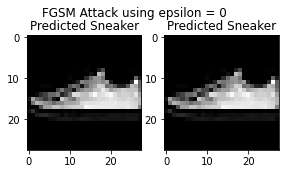

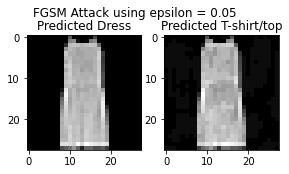

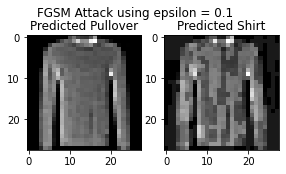

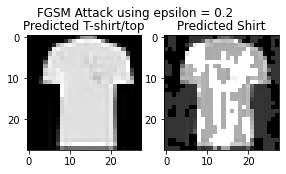

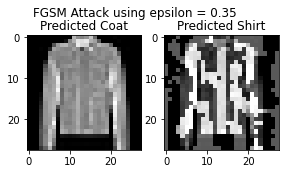

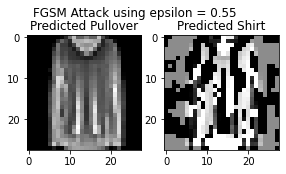

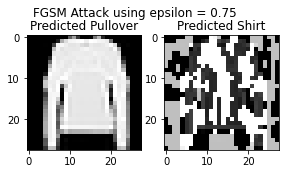

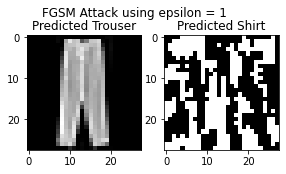

In [9]:
# Example printing, but I removed it to simplify results
for epsilon in epsilons:
    printing.print_attack(
        standard_model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

In [10]:
# Run test for each epsilon
for epsilon in epsilons:
    attacking.attack_model(
        standard_model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 91.23%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 46.74%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 16.37%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 1.82%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.48%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.27%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.35%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.66%




### I-FGSM / BIM (Iterative FGSM / Basic Iterative Method) https://arxiv.org/abs/1607.02533

The formula that is used for producing the adversarial example in this case is:

$x'_{0} = x$
$x'_{k + 1} = Clip_{x, \epsilon} \{x'_{k} + \alpha * sign(\nabla_{x}J(\theta, x'_{k}, y)\}$, where J is the loss function used. Note that in the paper proposing this method, $\alpha = 1$ is used, so pixels are changed by 1 in each iteration.

The formula for the clip function is also given in the paper.

In [11]:
import attacks.ifgsm as ifgsm

attacks["I-FGSM"] = ifgsm.ifgsm_attack

In [12]:
# Several values for epsilon. It's interesting to see how clamping affects results
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55]

In [13]:
for epsilon in epsilons:
    attacking.attack_model(
        standard_model,
        testSetLoader,
        "I-FGSM",
        attacks["I-FGSM"],
        epsilon=epsilon,
        alpha=1,
        iterations=3,
    )

Testing the model under I-FGSM Attack using epsilon = 0, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 91.23%


Testing the model under I-FGSM Attack using epsilon = 0.01568627450980392, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 44.58%


Testing the model under I-FGSM Attack using epsilon = 0.05, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 1.17%


Testing the model under I-FGSM Attack using epsilon = 0.1, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under I-FGSM Attack using epsilon = 0.2, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under I-FGSM Attack using epsilon = 0.35, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under I-FGSM Attack using epsilon = 0.55, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.0%




### PGD (Projected Gradient Descent) https://arxiv.org/pdf/1706.06083.pdf

The formula that is used for producing the adversarial example in this case is:

$x^{t+1} = \Pi_{x+S}(x^t+\alpha sgn(\bigtriangledown_x L(\theta, x, y)))$\n
where S is a set of allowed perturbations. Note that this is basically BIM with random initialisation. 

We use the $L_{\infty}$ norm here, i.e. we use clamping. 

In [14]:
import attacks.pgd as pgd

attacks["PGD"] = pgd.pgd_attack

In [15]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [16]:
for epsilon in epsilons:
    attacking.attack_model(
        standard_model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=20,
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 91.23%


Testing the model under PGD Attack using epsilon = 0.01568627450980392, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 77.28%


Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 38.02%


Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 8.18%


Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.12%


Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under PGD Attack using epsilon = 0.55, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under PGD Attack using epsilon = 0.75, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under PGD Attack using epsilon = 1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.0%




## From here, use existing libraries to simplify usageimport torchattacks


In [17]:
import torchattacks

### DeepFool https://arxiv.org/pdf/1511.04599.pdf

The formula here is complex, so I recommend for the interested reader to go the above link to read the full paper.

In [18]:
deepfool_attack = torchattacks.DeepFool(standard_model)

attacks["DeepFool"] = deepfool_attack

In [19]:
attacking.attack_model(
    standard_model,
    testSetLoader,
    "DeepFool",
    attacks["DeepFool"],
    library=True,
)

Testing the model under DeepFool Attack...


DeepFool Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.17%




### CW-$L_{2}$ (Carlini & Wagner using $L_{2}$ norm) https://arxiv.org/pdf/1608.04644.pdf

The formula here is complex, so I recommend for the interested reader to go the above link to read the full paper.

In [20]:
cw_attack = torchattacks.CW(standard_model, c=20)

attacks["CW"] = cw_attack

In [21]:
attacking.attack_model(
    standard_model,
    testSetLoader,
    "CW",
    attacks["CW"],
    library=True,
)

Testing the model under CW Attack...


CW Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.0%




## Adversarial Training

### FGSM Adversarial Training

In [22]:
# Weak epsilon 0.15, normal 0.35, strong 0.55
fgsm_model = fashion_mnist.adversarial_training(
    trainSetLoader,
    "FGSM",
    attacks["FGSM"],
    load_if_available=True,
    load_path=SAVE_LOAD_ROOT + "/fashion_mnist_fgsm",
    epsilon=0.45,
)

Found already trained model...
... loaded!


In [23]:
clean_test.test_trained_model(fgsm_model, testSetLoader)

Testing the model...


Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 50.51%


In [24]:
# Save the model
torch.save(fgsm_model, SAVE_LOAD_ROOT + "/fashion_mnist_fgsm")

In [25]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [26]:
# Run test for each epsilon
for epsilon in epsilons:
    attacking.attack_model(
        fgsm_model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 50.51%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 39.09%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 44.25%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 75.14%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 96.28%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 97.51%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 53.48%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 23.55%




In [27]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [28]:
for epsilon in epsilons:
    attacking.attack_model(
        fgsm_model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=7,
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 50.51%


Testing the model under PGD Attack using epsilon = 0.01568627450980392, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 40.08%


Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 25.36%


Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 17.77%


Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 12.02%


Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 8.48%


Testing the model under PGD Attack using epsilon = 0.55, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 1.31%


Testing the model under PGD Attack using epsilon = 0.75, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.17%


Testing the model under PGD Attack using epsilon = 1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.17%




### PGD Adversarial Training

In [29]:
pgd_model = fashion_mnist.adversarial_training(
    trainSetLoader,
    "PGD",
    attacks["PGD"],
    load_if_available=True,
    load_path=SAVE_LOAD_ROOT + "/fashion_mnist_pgd",
    epsilon=0.45,
    alpha=(2 / 255),
    iterations=7,
)

Found already trained model...
... loaded!


In [30]:
clean_test.test_trained_model(pgd_model, testSetLoader)

Testing the model...


Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 83.13%


In [31]:
# Save the model
torch.save(pgd_model, SAVE_LOAD_ROOT + "/fashion_mnist_pgd")

In [32]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [33]:
# Run test for each epsilon
for epsilon in epsilons:
    attacking.attack_model(
        pgd_model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 83.13%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 74.75%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 65.74%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 49.0%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 28.22%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 8.75%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 9.79%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 10.03%




In [34]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [35]:
for epsilon in epsilons:
    attacking.attack_model(
        pgd_model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=7,
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 83.13%


Testing the model under PGD Attack using epsilon = 0.01568627450980392, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 80.69%


Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 76.06%


Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 74.95%


Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 75.33%


Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 75.95%


Testing the model under PGD Attack using epsilon = 0.55, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 68.98%


Testing the model under PGD Attack using epsilon = 0.75, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 17.61%


Testing the model under PGD Attack using epsilon = 1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 9.54%




In [36]:
deepfool_attack = torchattacks.DeepFool(pgd_model)

attacks["DeepFool"] = deepfool_attack

In [37]:
# attacking.attack_model(
#     pgd_model,
#     testSetLoader,
#     "DeepFool",
#     attacks["DeepFool"],
#     library=True,
# )

In [38]:
cw_attack = torchattacks.CW(pgd_model, c=20)

attacks["CW"] = cw_attack

In [39]:
# attacking.attack_model(
#     pgd_model,
#     testSetLoader,
#     "CW",
#     attacks["CW"],
#     library=True,
# )

## Interpolated Adversarial Training

In [40]:
interpolated_pgd_model = fashion_mnist.interpolated_adversarial_training(
    trainSetLoader,
    "PGD",
    attacks["PGD"],
    load_if_available=True,
    load_path=SAVE_LOAD_ROOT + "/fashion_mnist_interpolated_pgd",
    epsilon=0.45,
    alpha=(2 / 255),
    iterations=7,
)

Found already trained model...
... loaded!


In [41]:
clean_test.test_trained_model(interpolated_pgd_model, testSetLoader)

Testing the model...


Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 87.67%


In [42]:
# Save the model
torch.save(interpolated_pgd_model, SAVE_LOAD_ROOT + "/fashion_mnist_interpolated_pgd")

In [43]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [44]:
# Run test for each epsilon
for epsilon in epsilons:
    attacking.attack_model(
        interpolated_pgd_model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 87.67%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 71.73%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 60.22%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 45.44%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 30.47%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 16.04%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 8.41%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 9.83%




In [45]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [46]:
for epsilon in epsilons:
    attacking.attack_model(
        interpolated_pgd_model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=7,
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 87.67%


Testing the model under PGD Attack using epsilon = 0.01568627450980392, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 82.31%


Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 72.38%


Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 69.85%


Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 71.16%


Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 74.39%


Testing the model under PGD Attack using epsilon = 0.55, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 68.35%


Testing the model under PGD Attack using epsilon = 0.75, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 22.16%


Testing the model under PGD Attack using epsilon = 1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 9.42%




## Dual / Triple Adversarial Training

In [47]:
dual_model = fashion_mnist.dual_adversarial_training(
    trainSetLoader,
    attacks["PGD"],
    attacks["FGSM"],
    load_if_available=True,
    load_path=SAVE_LOAD_ROOT + "/fashion_mnist_dual",
    epsilon=0.45,
    alpha=(2 / 255),
    iterations=7,
)

Found already trained model...
... loaded!


In [48]:
clean_test.test_trained_model(dual_model, testSetLoader)

Testing the model...


Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 83.12%


In [49]:
# Save the model
torch.save(dual_model, SAVE_LOAD_ROOT + "/fashion_mnist_dual")

In [50]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [51]:
# Run test for each epsilon
for epsilon in epsilons:
    attacking.attack_model(
        dual_model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 83.12%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 75.22%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 66.94%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 51.63%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 74.95%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 93.97%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 59.21%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 31.75%




In [52]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [53]:
for epsilon in epsilons:
    attacking.attack_model(
        dual_model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=7,
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 83.12%


Testing the model under PGD Attack using epsilon = 0.01568627450980392, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 80.74%


Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 76.12%


Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 74.5%


Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 73.86%


Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 73.25%


Testing the model under PGD Attack using epsilon = 0.55, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 64.36%


Testing the model under PGD Attack using epsilon = 0.75, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 6.37%


Testing the model under PGD Attack using epsilon = 1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 2.27%




In [54]:
deepfool_attack = torchattacks.DeepFool(dual_model)

attacks["DeepFool"] = deepfool_attack

In [55]:
# attacking.attack_model(
#     dual_model,
#     testSetLoader,
#     "DeepFool",
#     attacks["DeepFool"],
#     library=True,
# )

In [56]:
cw_attack = torchattacks.CW(dual_model, c=20)

attacks["CW"] = cw_attack

In [57]:
# attacking.attack_model(
#     dual_model,
#     testSetLoader,
#     "CW",
#     attacks["CW"],
#     library=True,
# )

In [58]:
triple_model = fashion_mnist.triple_adversarial_training(
    trainSetLoader,
    attacks["PGD"],
    attacks["FGSM"],
    "CW",
    load_if_available=True,
    load_path=SAVE_LOAD_ROOT + "/fashion_mnist_triple",
    epsilon=0.45,
    alpha=(2 / 255),
    iterations=7,
)

Found already trained model...
... loaded!


In [59]:
clean_test.test_trained_model(triple_model, testSetLoader)

Testing the model...


Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 87.95%


In [60]:
# Save the model
torch.save(triple_model, SAVE_LOAD_ROOT + "/fashion_mnist_triple")

In [61]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [62]:
# Run test for each epsilon
for epsilon in epsilons:
    attacking.attack_model(
        triple_model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 87.95%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 52.49%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 44.7%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 59.78%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 96.79%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 98.04%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 93.98%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 75.66%




In [63]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [64]:
for epsilon in epsilons:
    attacking.attack_model(
        triple_model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=7,
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 87.95%


Testing the model under PGD Attack using epsilon = 0.01568627450980392, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 73.0%


Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 51.57%


Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 48.53%


Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 54.77%


Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 70.55%


Testing the model under PGD Attack using epsilon = 0.55, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 66.13%


Testing the model under PGD Attack using epsilon = 0.75, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 38.74%


Testing the model under PGD Attack using epsilon = 1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 8.57%




In [65]:
deepfool_attack = torchattacks.DeepFool(triple_model)

attacks["DeepFool"] = deepfool_attack

In [66]:
# attacking.attack_model(
#     triple_model,
#     testSetLoader,
#     "DeepFool",
#     attacks["DeepFool"],
#     library=True,
# )

In [67]:
cw_attack = torchattacks.CW(triple_model, c=20)

attacks["CW"] = cw_attack

In [68]:
# attacking.attack_model(
#     triple_model,
#     testSetLoader,
#     "CW",
#     attacks["CW"],
#     library=True,
# )

### Variant of triple adversarial training using $L_{2}$ PGD

In [69]:
triple_variant_model = fashion_mnist.triple_adversarial_training(
    trainSetLoader,
    attacks["PGD"],
    attacks["FGSM"],
    "PGD",
    load_if_available=True,
    load_path=SAVE_LOAD_ROOT + "/fashion_mnist_triple_variant",
    epsilon=0.45,
    alpha=(2 / 255),
    iterations=7,
)

Found already trained model...
... loaded!


In [70]:
clean_test.test_trained_model(triple_variant_model, testSetLoader)

Testing the model...


Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 87.59%


In [71]:
# Save the model
torch.save(triple_variant_model, SAVE_LOAD_ROOT + "/fashion_mnist_triple_variant")

In [72]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [73]:
# Run test for each epsilon
for epsilon in epsilons:
    attacking.attack_model(
        triple_variant_model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 87.59%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 77.49%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 66.14%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 49.69%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 91.31%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 96.9%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 89.11%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 68.34%




In [74]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [75]:
for epsilon in epsilons:
    attacking.attack_model(
        triple_variant_model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=7,
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 87.59%


Testing the model under PGD Attack using epsilon = 0.01568627450980392, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 84.92%


Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 78.59%


Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 75.61%


Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 73.77%


Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 72.28%


Testing the model under PGD Attack using epsilon = 0.55, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 67.12%


Testing the model under PGD Attack using epsilon = 0.75, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 24.61%


Testing the model under PGD Attack using epsilon = 1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 3.11%




In [76]:
deepfool_attack = torchattacks.DeepFool(triple_variant_model)

attacks["DeepFool"] = deepfool_attack

In [77]:
attacking.attack_model(
    triple_variant_model,
    testSetLoader,
    "DeepFool",
    attacks["DeepFool"],
    library=True,
)

Testing the model under DeepFool Attack...


DeepFool Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.23%




In [78]:
cw_attack = torchattacks.CW(triple_variant_model, c=20)

attacks["CW"] = cw_attack

In [79]:
attacking.attack_model(
    triple_variant_model,
    testSetLoader,
    "CW",
    attacks["CW"],
    library=True,
)

Testing the model under CW Attack...


CW Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 1.35%




## Jacobian Regularization Training

In [80]:
jacobian_model = fashion_mnist.jacobian_training(
    trainSetLoader,
    load_if_available=True,
    load_path=SAVE_LOAD_ROOT + "/mnist_jacobian",
)

Found already trained model...
... loaded!


In [81]:
clean_test.test_trained_model(jacobian_model, testSetLoader)

Testing the model...


Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 89.37%


In [82]:
# Save the model
torch.save(jacobian_model, SAVE_LOAD_ROOT + "/mnist_jacobian")

In [83]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [84]:
# Run test for each epsilon
for epsilon in epsilons:
    attacking.attack_model(
        jacobian_model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 89.37%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 69.17%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 47.6%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 18.19%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 5.15%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 6.1%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 7.77%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 9.0%




In [85]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [86]:
for epsilon in epsilons:
    attacking.attack_model(
        jacobian_model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=7,
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 89.37%


Testing the model under PGD Attack using epsilon = 0.01568627450980392, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 83.51%


Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 70.76%


Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 63.55%


Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 56.41%


Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 46.26%


Testing the model under PGD Attack using epsilon = 0.55, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 25.33%


Testing the model under PGD Attack using epsilon = 0.75, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 12.12%


Testing the model under PGD Attack using epsilon = 1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 8.1%




In [87]:
deepfool_attack = torchattacks.DeepFool(jacobian_model)

attacks["DeepFool"] = deepfool_attack

In [88]:
attacking.attack_model(
    jacobian_model,
    testSetLoader,
    "DeepFool",
    attacks["DeepFool"],
    library=True,
)

Testing the model under DeepFool Attack...


DeepFool Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.11%




In [89]:
cw_attack = torchattacks.CW(jacobian_model, c=20)

attacks["CW"] = cw_attack

In [90]:
attacking.attack_model(
    jacobian_model,
    testSetLoader,
    "CW",
    attacks["CW"],
    library=True,
)

Testing the model under CW Attack...


CW Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.04%




## ALP Training

In [91]:
alp_model = fashion_mnist.ALP_training(
    trainSetLoader,
    "PGD",
    attacks["PGD"],
    load_if_available=True,
    load_path=SAVE_LOAD_ROOT + "/fashion_mnist_alp",
    epsilon=0.45,
    alpha=(2 / 255),
    iterations=7,
)

Found already trained model...
... loaded!


In [92]:
clean_test.test_trained_model(alp_model, testSetLoader)

Testing the model...


Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 90.38%


In [93]:
# Save the model
torch.save(alp_model, SAVE_LOAD_ROOT + "/fashion_mnist_alp")

In [94]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [95]:
# Run test for each epsilon
for epsilon in epsilons:
    attacking.attack_model(
        alp_model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 90.38%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 66.31%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 50.29%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 31.39%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 13.88%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 4.66%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 3.87%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 4.35%




In [96]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [97]:
for epsilon in epsilons:
    attacking.attack_model(
        alp_model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=7,
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 90.38%


Testing the model under PGD Attack using epsilon = 0.01568627450980392, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 83.35%


Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 67.53%


Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 62.56%


Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 62.3%


Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 65.28%


Testing the model under PGD Attack using epsilon = 0.55, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 63.75%


Testing the model under PGD Attack using epsilon = 0.75, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 47.55%


Testing the model under PGD Attack using epsilon = 1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 19.38%




In [98]:
deepfool_attack = torchattacks.DeepFool(alp_model)

attacks["DeepFool"] = deepfool_attack

In [99]:
attacking.attack_model(
    alp_model,
    testSetLoader,
    "DeepFool",
    attacks["DeepFool"],
    library=True,
)

Testing the model under DeepFool Attack...


DeepFool Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.13%




In [100]:
cw_attack = torchattacks.CW(alp_model, c=20)

attacks["CW"] = cw_attack

In [101]:
attacking.attack_model(
    alp_model,
    testSetLoader,
    "CW",
    attacks["CW"],
    library=True,
)

Testing the model under CW Attack...


CW Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.07%




## Jacobian + ALP Training

In [102]:
jacobian_alp_model = fashion_mnist.jacobian_ALP_training(
    trainSetLoader,
    "PGD",
    attacks["PGD"],
    load_if_available=True,
    load_path=SAVE_LOAD_ROOT + "/fashion_mnist_jacobian_alp",
    epsilon=0.45,
    alpha=(2 / 255),
    iterations=7,
)

Found already trained model...
... loaded!


In [103]:
clean_test.test_trained_model(jacobian_alp_model, testSetLoader)

Testing the model...


Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 88.81%


In [104]:
# Save the model
torch.save(jacobian_alp_model, SAVE_LOAD_ROOT + "/fashion_mnist_jacobian_alp")

In [105]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [106]:
# Run test for each epsilon
for epsilon in epsilons:
    attacking.attack_model(
        jacobian_alp_model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 88.81%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 72.36%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 57.14%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 36.03%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 13.2%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 6.44%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 4.89%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 5.03%




In [107]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [108]:
for epsilon in epsilons:
    attacking.attack_model(
        jacobian_alp_model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=7,
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 88.81%


Testing the model under PGD Attack using epsilon = 0.01568627450980392, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 83.75%


Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 74.07%


Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 69.99%


Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 67.93%


Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 66.31%


Testing the model under PGD Attack using epsilon = 0.55, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 61.93%


Testing the model under PGD Attack using epsilon = 0.75, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 53.1%


Testing the model under PGD Attack using epsilon = 1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 27.44%




In [109]:
deepfool_attack = torchattacks.DeepFool(jacobian_alp_model)

attacks["DeepFool"] = deepfool_attack

In [110]:
attacking.attack_model(
    jacobian_alp_model,
    testSetLoader,
    "DeepFool",
    attacks["DeepFool"],
    library=True,
)

Testing the model under DeepFool Attack...


DeepFool Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.07%




In [111]:
cw_attack = torchattacks.CW(jacobian_alp_model, c=20)

attacks["CW"] = cw_attack

In [112]:
attacking.attack_model(
    jacobian_alp_model,
    testSetLoader,
    "CW",
    attacks["CW"],
    library=True,
)

Testing the model under CW Attack...


CW Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.18%


